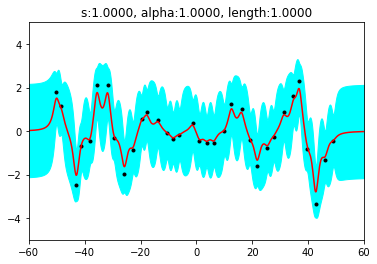

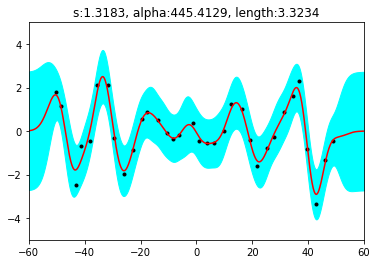

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


def getData(filepath='data/input.data'):
    X = []
    Y = []
    with open(filepath, 'r') as fo:
        lines = fo.readlines()
    for line in lines:
        line = line.strip().split()
        X.append(float(line[0]))
        Y.append(float(line[1]))
    X = np.array(X).reshape(-1, 1)
    Y = np.array(Y).reshape(-1, 1)
    return X, Y


def rationalQudraticKernel(x1, x2, sigma=1., alpha=1., length=1.):
    return (sigma**2) * (1 + (x1 - x2)**2/(2 * alpha * length**2))**(-alpha)


def covariance(X, beta, sigma, alpha, length):
    C = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            C[i][j] = rationalQudraticKernel(X[i], X[j], sigma, alpha, length)
        C[i][i] += 1/beta
    return C


def GaussianProcess(X, Y, beta, sigma, alpha, length):
    points = 1000
    mean = np.zeros((points))
    var = np.zeros((points))
    x_test = np.linspace(-60, 60, points)
    C = covariance(X, beta, sigma, alpha, length)
                
    for i in range(points):
        K = np.zeros((X.shape[0], 1))
        for j in range(X.shape[0]):
            K[j] = rationalQudraticKernel(X[j], x_test[i], sigma, alpha, length)
        mean[i] = K.T.dot(np.linalg.inv(C)).dot(Y)
        k_s = rationalQudraticKernel(x_test[i], x_test[i], sigma, alpha, length) + 1/beta
        var[i] = k_s - K.T.dot(np.linalg.inv(C)).dot(K)

    fig = plt.figure()
    interval = 1.96 * (var ** 0.5) # 95% Confidence Interval
    
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(f's:{sigma:.4f}, alpha:{alpha:.4f}, length:{length:.4f}')
    ax.plot(X, Y, "k.")
    ax.plot(x_test, mean, "r-")
    ax.fill_between(x_test, mean + interval, mean - interval, color='cyan')
    ax.set_xlim([-60, 60])
    ax.set_ylim([-5, 5])
    plt.show()

# 取negative的likelihood，這樣才能minimize
def negativeMarginalLikelihood(theta, X, Y, beta):
    theta = theta.reshape(len(theta), 1)
    C = covariance(X, beta, theta[0], theta[1], theta[2])
    likelihood = 0.5 * (np.log(np.linalg.det(C)) + Y.T.dot(np.linalg.inv(C)).dot(Y) + np.log(2 * np.pi) * X.shape[0])
    #likelihood = np.log(np.linalg.det(C)) * 0.5
    #likelihood += Y.T.dot(np.linalg.inv(C)).dot(Y) * 0.5
    #likelihood += np.log(2 * np.pi) * X.shape[0] * 0.5
    return likelihood[0]


if __name__ == '__main__':
    X, Y = getData()
    beta = 5
    sigma = 1
    alpha = 1
    length = 1

    GaussianProcess(X, Y, beta, sigma, alpha, length)

    # Optimize parameters
    opt = minimize(negativeMarginalLikelihood, [sigma, alpha, length], args=(X, Y, beta))
    
    sigma = opt.x[0]
    alpha = opt.x[1]
    length = opt.x[2]

    GaussianProcess(X, Y, beta, sigma, alpha, length)
    